# Spike detection and ffnn to predict parameters of the model
- Workswith python 3.
- Treats chans as units
- No LFP


In [1]:
# Definitions and functions
%matplotlib inline
import pdb
import sys
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os
import wave
import struct
import h5py
from scipy.io import wavfile
from scipy.signal import spectrogram
import logging
from IPython.display import display
matplotlib.style.use('ggplot')
from ipywidgets import *
import yaml
import numpy.lib.recfunctions as rfn 
import numpy.matlib as npm
import glob
from tqdm import tqdm


# Check wich computer to decide where the things are mounted
comp_name=socket.gethostname()
print( 'Computer: ' + comp_name)

if 'txori' in comp_name or 'passaro' in comp_name or 'niao' in comp_name:
    print('known machine')
    repos_folder = os.path.abspath('/mnt/cube/earneodo/repos')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')

sys.path.append(os.path.join(repos_folder, 'ephysflow'))
#sys.path.append(os.path.join(repos_folder, 'analysis-tools'))
sys.path.append(os.path.join(repos_folder, 'swissknife'))

from swissknife.bci.core import expstruct as et

from basic_viewing import events as evt

from swissknife.bci.core import expstruct as et
from swissknife.bci.core import kwik_functions as kwkf
from swissknife.bci.core.file import h5_functions as kwdf

from swissknife.bci import synthetic as syn
from swissknife.bci import unitmeta as um
from swissknife.bci import stimalign as sta

from swissknife.bci.units import Unit, threshUnit
from swissknife.bci import units as unitobjs

from swissknife.bci.core.basic_plot import plot_raster, sparse_raster
from swissknife.bci.core import basic_plot as bp

from swissknife.decoder import linear as ld
from swissknife.decoder import neural as nd

from swissknife.h5tools import h5tools as h5
from swissknife.streamtools import streams as st
from swissknife.streamtools import spectral as sp
from swissknife.streamtools import temporal as tp


#import spike_detect_aux as aux

#from importlib import reload
logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)



print('All modules loaded')

Computer: passaro
known machine
All modules loaded


# Functions for collecting and manipulating frames of data

In [2]:
def band_pass_filter(chunk, hp_b, hp_a, lp_b, lp_a):    
    chunk_hi = sg.filtfilt(hp_b, hp_a, chunk)
    chunk_filt = sg.filtfilt(lp_b, lp_a, chunk_hi)
    return chunk_filt

def filter_rms(x, filter_pars):
    return st.rms(sp.apply_butter_bandpass(x, filter_pars))

def list_sum(a_list):
    s = a_list.pop(-1)
    for new_s in a_list:
        s+=new_s
    return s

def collect_frames(starts, span, s_f, kwd_file, recs_list, chan_list):
    frames = []

    logger.info('Collecting {} frames...'.format(starts.size))
    for i_start, start in enumerate(starts):
        if i_start % 10 == 0:
            logger.info("Frame {} ...".format(i_start))
        rec = recs_list[i_start]
        one_frame = st.Chunk(st.H5Data(kwdf.get_data_set(kwd_file, rec),
                                       s_f,
                                       dtype=np.float),
                             np.array(chan_list),
                             [start, start + span])
        frames.append(one_frame)
    return frames

def spikes_array(chunk, thresholds, min_dist=10):
    #logger.info('Getting spikes from chunk with data sized {}'.format(chunk.data.shape))
    spk_lst = tp.find_spikes(chunk.data, thresholds, min_dist=min_dist)
    spk_arr = np.zeros_like(chunk.data)
    assert(len(spk_lst)==spk_arr.shape[1])
    for ch in range(len(spk_lst)):
        spk_arr[spk_lst[ch], ch] = 1
    return spk_arr

def collect_all_spk_arr(frames_list, thresholds, min_dist=10):
    return np.stack([spikes_array(fr, thresholds, min_dist=min_dist) for fr in frames_list], axis=0)

def normalize(u):
    u_max = np.repeat(np.amax(u, axis = 1, keepdims=True), u.shape[-1], axis=1)
    u_min = np.repeat(np.amin(u, axis = 1, keepdims=True), u.shape[-1], axis=1)
    u_range = u_max - u_min
    return (u - u_min)/u_range

# Definitions for the session and templates of the parameters

In [3]:
# bird and session
bird = 'z007'
sess = 'day-2016-09-10'
stim_sess = '001'

spectrogram_pars={'n_window': 512,
                 'n_overlap': 511,
                 'sigma': 30,
                 'f_cut': 10000,
                 'db_cut': 0.000065 }

filter_band = [500, 10000]

exp_par = et.get_parameters(bird, sess)
fn = et.file_names(bird, sess)
song_file_path = et.file_path(fn, 'ss', 'sng')
song_file = h5py.File(song_file_path, 'r')

pattern_names = exp_par['search_motiff']['motiff_patterns']
print(pattern_names)

{'motiff_1': 'motiff_1.wav'}


550.4
fcut_plot 10000


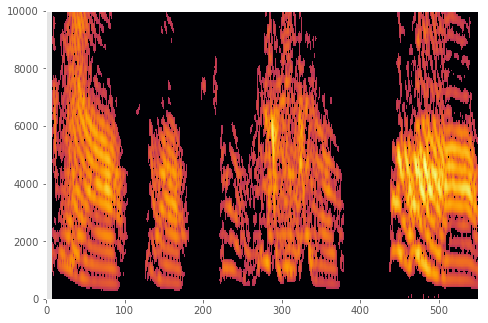

In [4]:
#pattern
m_name = 'motiff_1'
m_path = os.path.join(et.file_names(bird)['folders']['stim'], stim_sess, 
                      exp_par['search_motiff']['motiff_patterns'][m_name])

m = evt.Song(m_name, song_file)
m_chunk = st.Chunk(st.WavData2(m_path))
#plt.plot(m_chunk.data)

s_f = m_chunk.sound.s_f
filter_pars = sp.make_butter_bandpass(s_f, filter_band[0], filter_band[1])

spec_obj = sp.Spectrogram(m_chunk.data[:,0], s_f, **spectrogram_pars)
ax = spec_obj.plot()

### Testing the pretty_spectrogram

/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in true_divide


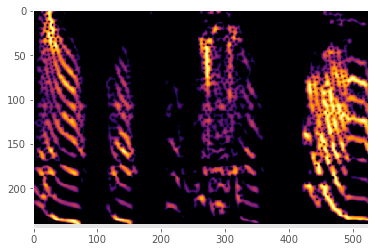

In [5]:
win_s = .001
win_samples = 128*8
step_s = .001
f_cut = 15000

#n_perseg = int(s_f * win_s)
n_perseg = win_samples

s_f = 30000
#n_overlap = int(s_f * (win_s - step_s))
n_overlap = win_samples - int(s_f*step_s)


#reload(sp)
f, t, s = sp.pretty_spectrogram(m_chunk.data[:,0], s_f, fft_size=n_perseg, log=True,
                      step_size=int(s_f*step_s), db_cut=65,
                     f_min=300, f_max=7500, window=('gaussian', 80))
plt.imshow(normalize((s))[::-1], aspect='auto', cmap='inferno')
plt.grid(False)

## Testing the frame chopping and visualizing

In [6]:
from importlib import reload

In [7]:
reload(kwkf)

<module 'swissknife.bci.core.kwik_functions' from '/mnt/cube/earneodo/repos/swissknife/swissknife/bci/core/kwik_functions.py'>

2017-06-29 15:10:24,228 root         DEBUG    H5 file: <HDF5 file "experiment.raw.kwd" (mode r)>
2017-06-29 15:10:24,230 root         DEBUG    H5 file: <HDF5 file "experiment.raw.kwd" (mode r)>
2017-06-29 15:10:24,231 root         DEBUG    H5 file: <HDF5 file "experiment.raw.kwd" (mode r)>
2017-06-29 15:10:24,232 root         DEBUG    H5 file: <HDF5 file "experiment.raw.kwd" (mode r)>
2017-06-29 15:10:24,233 root         DEBUG    H5 file: <HDF5 file "experiment.raw.kwd" (mode r)>
2017-06-29 15:10:24,234 root         DEBUG    H5 file: <HDF5 file "experiment.raw.kwd" (mode r)>
2017-06-29 15:10:24,235 root         DEBUG    H5 file: <HDF5 file "experiment.raw.kwd" (mode r)>
2017-06-29 15:10:24,236 root         DEBUG    H5 file: <HDF5 file "experiment.raw.kwd" (mode r)>
2017-06-29 15:10:24,237 root         DEBUG    H5 file: <HDF5 file "experiment.raw.kwd" (mode r)>
2017-06-29 15:10:24,238 root         DEBUG    H5 file: <HDF5 file "experiment.raw.kwd" (mode r)>
2017-06-29 15:10:24,240 root  

(27768, 32)

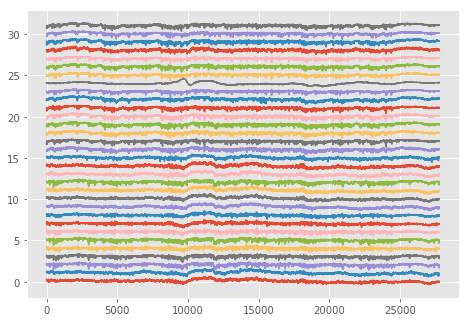

In [8]:
kwd_file = et.open_kwd(bird, sess)
starts = m.get_start()
recs = m.get_rec()

m_starts = kwkf.apply_rec_offset(kwd_file, m.get_start(), m.get_rec())

i_bout = 29
#neural_chans = np.array(exp_par['channel_config']['neural'] + [exp_par['channel_config']['mic']])
neural_chans = np.array(exp_par['channel_config']['neural'])
before = 5000
after = 6000
#neural_chans = np.array([19, 23, 25, 26, 27, 29])
rec = recs[i_bout]
dset = kwdf.get_data_set(kwd_file, rec)
h5d = st.H5Data(dset, s_f, dtype=np.float, chan_list=neural_chans)
start = starts[i_bout]

lfp_frame = st.Chunk(h5d, chan_list = h5d.chan_list, segment=[start-before, start + m_chunk.samples + after])
#lfp_frame.apply_filter(sp.apply_butter_bandpass, filter_pars)

lfp_frame.plot();
lfp_frame.data.shape
#kwd_file.close()

# Definitions and functions to collect array of spectrograms 

### for all channels in one frame

In [9]:
np.max(starts)

433240010

In [10]:
np.max(m_starts)

461702810

In [11]:
# one channel spectrogram
reload(sp)
i_ch = 3
win_s = .001
win_samples = 128*16
step_s = .001
f_cut = 15000

lfp_pars = {'f_min': 0,
            'f_max': 500,
            'win_samples': 128*8,
            'step_samples': int(step_s * s_f),
            'db_cut': 90,
            's_f': s_f}
    
def array_spectrogram(x, pars, axis=-1):
    y = x.T if axis==0 else x
    t_steps, n_ch = y.shape
    
    spec_tower =[]
    for i_ch in range(n_ch):
        f, t, s = sp.pretty_spectrogram(x[:,i_ch], pars['s_f'], 
                                        fft_size=pars['win_samples'], 
                                        log=True,
                                        step_size=pars['step_samples'], db_cut=pars['db_cut'],
                                        f_min=pars['f_min'], f_max=pars['f_max'], 
                                        window=('gaussian', pars['win_samples']//4))
        
        spec_tower.append(s)
    return np.stack(spec_tower, axis=0)


all_frames = unitobjs.collect_frames(starts-before, before+after+m_chunk.samples, 
                            s_f, 
                            kwd_file, neural_chans, recs=recs)

frame_spec = array_spectrogram(all_frames[0].data, pars=lfp_pars)
#plt.imshow(((s))[::-1], aspect='auto', cmap='inferno')

frame_spec.shape

2017-06-29 15:10:29,621 root         DEBUG    H5 file: <HDF5 file "experiment.raw.kwd" (mode r)>
2017-06-29 15:10:29,623 swissknife.bci.core.units INFO     Collecting 71 frames...
2017-06-29 15:10:29,624 swissknife.bci.core.units INFO     Frame 0 ...
2017-06-29 15:10:29,626 root         DEBUG    H5 file: <HDF5 file "experiment.raw.kwd" (mode r)>
2017-06-29 15:10:29,627 root         DEBUG    Getting dataset from rec 0
2017-06-29 15:10:29,637 root         DEBUG    H5 file: <HDF5 file "experiment.raw.kwd" (mode r)>
2017-06-29 15:10:29,638 root         DEBUG    Getting dataset from rec 0
2017-06-29 15:10:29,650 root         DEBUG    H5 file: <HDF5 file "experiment.raw.kwd" (mode r)>
2017-06-29 15:10:29,651 root         DEBUG    Getting dataset from rec 0
2017-06-29 15:10:29,661 root         DEBUG    H5 file: <HDF5 file "experiment.raw.kwd" (mode r)>
2017-06-29 15:10:29,663 root         DEBUG    Getting dataset from rec 0
2017-06-29 15:10:29,672 root         DEBUG    H5 file: <HDF5 file "ex

2017-06-29 15:10:30,083 root         DEBUG    Getting dataset from rec 4
2017-06-29 15:10:30,091 root         DEBUG    H5 file: <HDF5 file "experiment.raw.kwd" (mode r)>
2017-06-29 15:10:30,092 root         DEBUG    Getting dataset from rec 4
2017-06-29 15:10:30,107 root         DEBUG    H5 file: <HDF5 file "experiment.raw.kwd" (mode r)>
2017-06-29 15:10:30,107 root         DEBUG    Getting dataset from rec 4
2017-06-29 15:10:30,119 root         DEBUG    H5 file: <HDF5 file "experiment.raw.kwd" (mode r)>
2017-06-29 15:10:30,121 root         DEBUG    Getting dataset from rec 4
2017-06-29 15:10:30,129 root         DEBUG    H5 file: <HDF5 file "experiment.raw.kwd" (mode r)>
2017-06-29 15:10:30,130 root         DEBUG    Getting dataset from rec 4
2017-06-29 15:10:30,138 swissknife.bci.core.units INFO     Frame 50 ...
2017-06-29 15:10:30,139 root         DEBUG    H5 file: <HDF5 file "experiment.raw.kwd" (mode r)>
2017-06-29 15:10:30,140 root         DEBUG    Getting dataset from rec 4
2017-

(32, 18, 892)

### For all frames in a stack (list)

In [12]:
def collect_all_spectra(all_frames, lfp_pars):
    all_spectra= []
    for i, fr in tqdm(enumerate(all_frames)):
        one_s = array_spectrogram(fr.data, lfp_pars, axis=-1)
        all_spectra.append(one_s)

    all_spectra_array = np.stack(all_spectra, axis=0)
    return all_spectra_array

all_spec_array = collect_all_spectra(all_frames, lfp_pars)
logger.info('{}'.format(all_spec_array.shape))

71it [01:10,  1.00s/it]
2017-06-29 15:11:42,050 root         INFO     (71, 32, 18, 892)


In [13]:
[n_frames, n_chans, n_bands, n_steps] = all_spec_array.shape
all_spectra_sv = all_spec_array.reshape([n_frames, -1, n_steps])
all_spectra_sv.shape
#plt.imshow(all_spectra_sv)

(71, 576, 892)

In [14]:
# logarithmic frequency bands

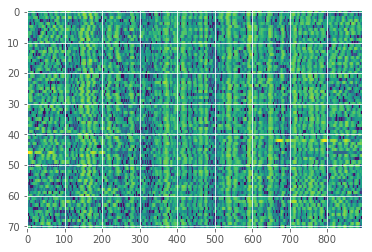

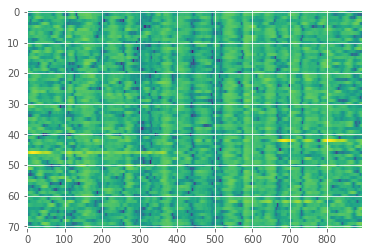

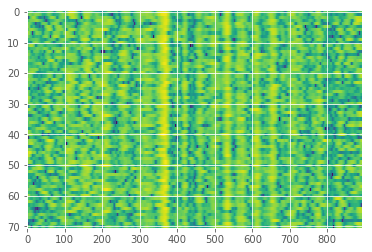

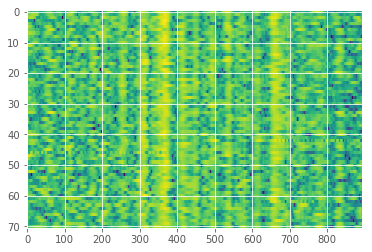

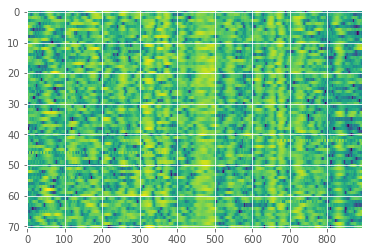

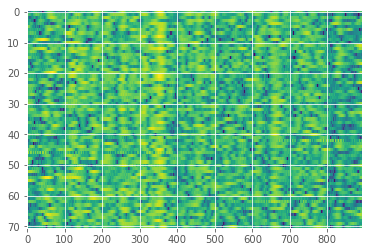

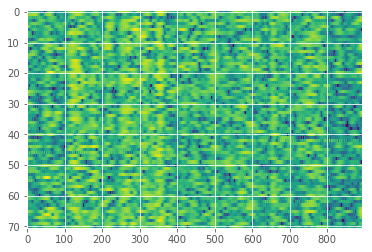

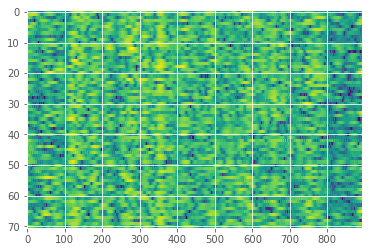

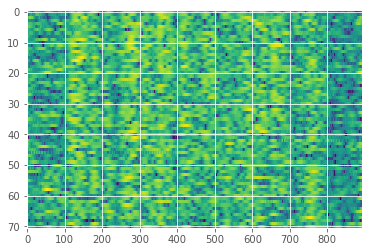

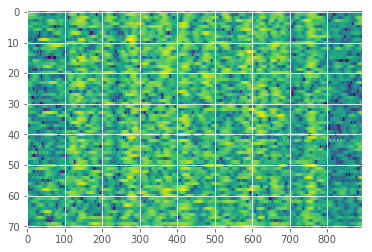

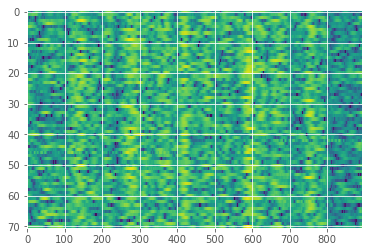

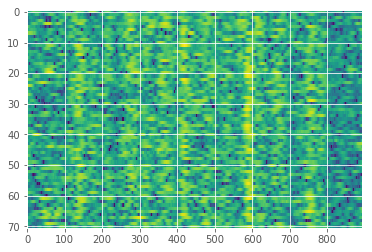

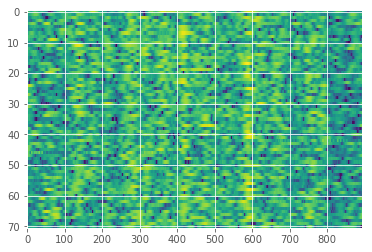

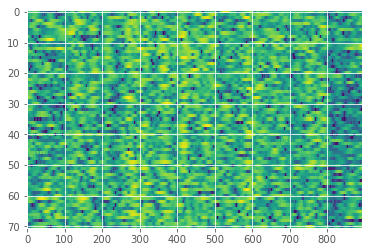

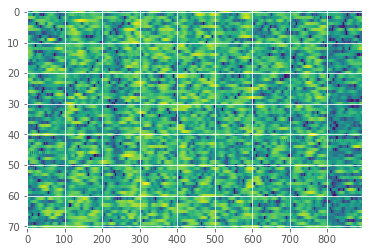

In [15]:
# view LFP BAND 'RASTERS'
ch = 30
for band in range(15):
    plt.figure()
    plt.imshow(all_spec_array[:,ch, band,:], aspect='auto')    

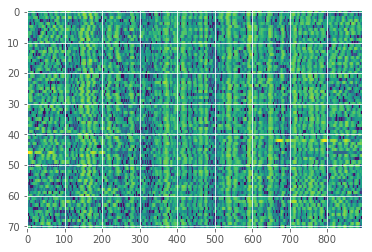

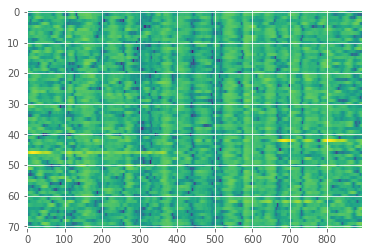

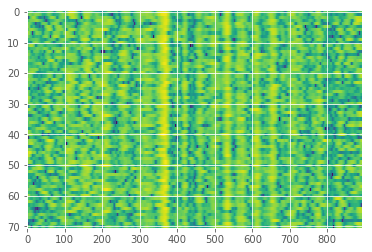

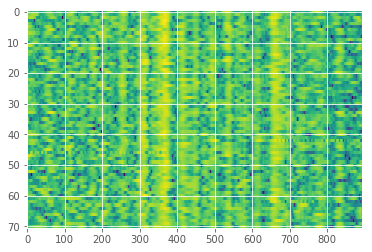

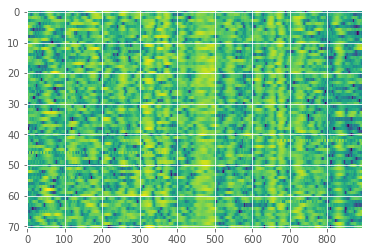

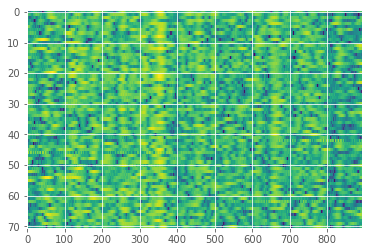

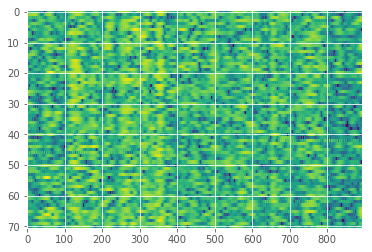

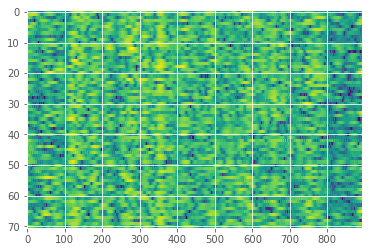

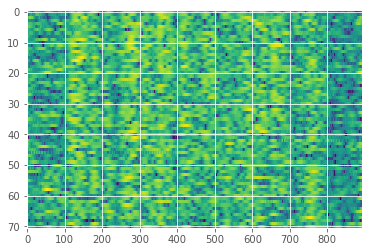

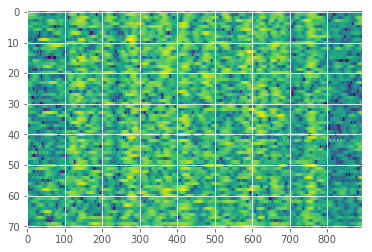

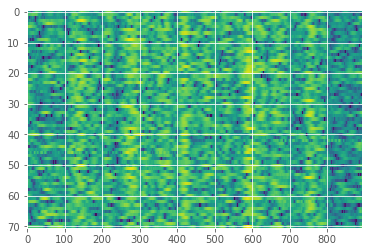

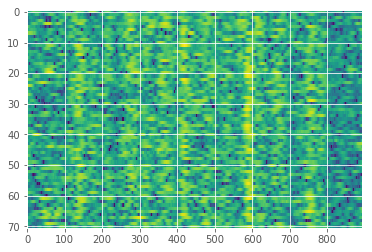

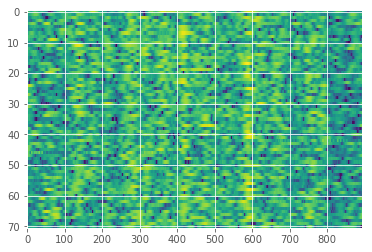

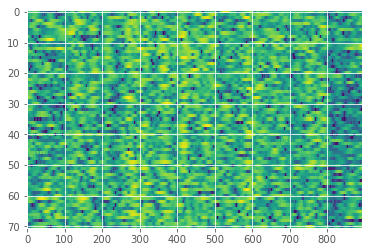

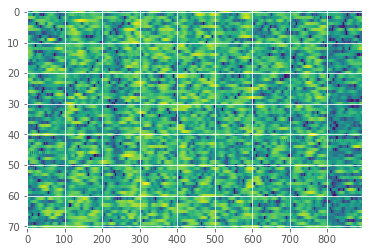

In [16]:
# view LFP BAND 'RASTERS' from the squeezed all_spectra_sv
ch = 30
for band in range(15):
    plt.figure()
    plt.imshow(all_spectra_sv[:,ch*n_bands + band,:], aspect='auto')  

In [17]:
lfp_pars

{'db_cut': 90,
 'f_max': 500,
 'f_min': 0,
 's_f': 30000,
 'step_samples': 30,
 'win_samples': 1024}

# Making freature vectors (arrays)

### Lfp feature vectors

In [18]:
def feature_vector_from_lfp(starts, recs, len_samples, channels, kwd_file, lfp_pars,
                            bin_size=10, s_f=30000, history_bins=1, no_silent=True):
    logger.info('Starts shape {}'.format(starts.shape))
    bin_size_samples = int(bin_size * s_f / 1000.)
    len_bin = int(len_samples / bin_size_samples)
    len_ms = int(len_bin * bin_size)
    history_samples = history_bins * bin_size_samples
    window_samples = lfp_pars['win_samples']
    span_ms = len_ms + bin_size * history_bins
    span_samples = int(span_ms * s_f / 1000.)

    logger.info('span_ms = {}'.format(span_ms))
    logger.info('bin_ms = {}'.format(bin_size))
    
    all_frames = collect_frames(starts - history_samples - window_samples,
                                span_samples + window_samples,
                                s_f,
                                kwd_file,
                                recs,
                                channels)
    
    logger.info('Frame shape {}'.format(all_frames[0].data.shape))
    # collect all the spectral bands for all the frames in all the channels
    logger.info('Collecting the spectral features for the {} frames'.format(starts.size))
    
    all_spec_array = collect_all_spectra(all_frames, lfp_pars)
    logger.info('all_spec_array shape {}'.format(all_spec_array.shape))

    # reshape it into a [n_frame, n_chans*n_bands, n_steps] array
    [n_frames, n_chans, n_bands, n_steps] = all_spec_array.shape
    
    all_spectra_fv = all_spec_array.reshape([n_frames, -1, n_steps])
    
    logger.info('all_spectra_fv shape = {}'.format(all_spectra_fv.shape))
    
    all_spectra_sv = np.stack([bp.col_binned(all_spectra_fv[t,:,:span_ms], bin_size) 
                               for t in range(n_frames)], axis=2)
    
    return all_spectra_sv/np.max(all_spectra_sv), all_spectra_fv


### Supra-threshold events feature vectors

In [60]:

reload(unitobjs)
trials_train = np.arange(65)
trials_test = np.arange(65,71)

def find_silent(sup_vec):
    silent_list = np.array([any(~(sup_vec[i,:,:].any(axis=0))) for i in range(sup_vec.shape[0])])
    return silent_list


# set the threshold factors
bin_size = 5
history_bins = 10
spike_thresh = 4.5

chans_list = np.array(exp_par['channel_config']['neural'])
units_list = [unitobjs.threshUnit(ch, kwd_file=kwd_file) for ch in chans_list]
#chan_unit = unitobjs.threshUnit(0, kwd_file=kwd_file)

[x.set_thresh_factor(spike_thresh)for x in units_list];
sv, good_chans = unitobjs.support_vector_thresh(m_starts, m_chunk.samples, units_list,
                                   bin_size=bin_size, s_f=s_f, history_bins=history_bins,
                                   no_silent=False)

#sv_old=support_vector_from_raw(starts, recs, m_chunk.samples, neural_chans, thresh, kwd_file)
logger.info('sv shape: {}'.format(sv.shape))

2017-06-29 20:45:19,181 swissknife.bci.core.units INFO     Collecting 71 frames...
2017-06-29 20:45:19,182 swissknife.bci.core.units INFO     Frame 0 ...
2017-06-29 20:45:19,233 swissknife.bci.core.units INFO     Frame 10 ...
2017-06-29 20:45:19,281 swissknife.bci.core.units INFO     Frame 20 ...
2017-06-29 20:45:19,326 swissknife.bci.core.units INFO     Frame 30 ...
2017-06-29 20:45:19,364 swissknife.bci.core.units INFO     Frame 40 ...
2017-06-29 20:45:19,399 swissknife.bci.core.units INFO     Frame 50 ...
2017-06-29 20:45:19,433 swissknife.bci.core.units INFO     Frame 60 ...
2017-06-29 20:45:19,467 swissknife.bci.core.units INFO     Frame 70 ...
2017-06-29 20:45:21,033 swissknife.bci.core.units INFO     Will get spikes form 71 frams
2017-06-29 20:45:22,635 root         INFO     sv shape: (32, 121, 71)


In [20]:
lsv, _= feature_vector_from_lfp(starts, recs, m_chunk.samples, neural_chans, kwd_file, lfp_pars)
print(lsv.shape)

2017-06-29 15:11:52,919 root         INFO     Starts shape (71,)
2017-06-29 15:11:52,920 root         INFO     span_ms = 560
2017-06-29 15:11:52,921 root         INFO     bin_ms = 10
2017-06-29 15:11:52,922 root         INFO     Collecting 71 frames...
2017-06-29 15:11:52,923 root         INFO     Frame 0 ...
2017-06-29 15:11:52,925 root         DEBUG    H5 file: <HDF5 file "experiment.raw.kwd" (mode r)>
2017-06-29 15:11:52,926 root         DEBUG    Getting dataset from rec 0
2017-06-29 15:11:52,930 root         DEBUG    H5 file: <HDF5 file "experiment.raw.kwd" (mode r)>
2017-06-29 15:11:52,931 root         DEBUG    Getting dataset from rec 0
2017-06-29 15:11:52,936 root         DEBUG    H5 file: <HDF5 file "experiment.raw.kwd" (mode r)>
2017-06-29 15:11:52,937 root         DEBUG    Getting dataset from rec 0
2017-06-29 15:11:52,941 root         DEBUG    H5 file: <HDF5 file "experiment.raw.kwd" (mode r)>
2017-06-29 15:11:52,942 root         DEBUG    Getting dataset from rec 0
2017-06-2

2017-06-29 15:11:53,165 root         DEBUG    H5 file: <HDF5 file "experiment.raw.kwd" (mode r)>
2017-06-29 15:11:53,166 root         DEBUG    Getting dataset from rec 4
2017-06-29 15:11:53,170 root         DEBUG    H5 file: <HDF5 file "experiment.raw.kwd" (mode r)>
2017-06-29 15:11:53,171 root         DEBUG    Getting dataset from rec 4
2017-06-29 15:11:53,175 root         DEBUG    H5 file: <HDF5 file "experiment.raw.kwd" (mode r)>
2017-06-29 15:11:53,176 root         DEBUG    Getting dataset from rec 4
2017-06-29 15:11:53,181 root         DEBUG    H5 file: <HDF5 file "experiment.raw.kwd" (mode r)>
2017-06-29 15:11:53,182 root         DEBUG    Getting dataset from rec 4
2017-06-29 15:11:53,186 root         DEBUG    H5 file: <HDF5 file "experiment.raw.kwd" (mode r)>
2017-06-29 15:11:53,186 root         DEBUG    Getting dataset from rec 4
2017-06-29 15:11:53,192 root         INFO     Frame 50 ...
2017-06-29 15:11:53,195 root         DEBUG    H5 file: <HDF5 file "experiment.raw.kwd" (mod

(576, 56, 71)


In [21]:
print(sv.shape)
print(lsv.shape)

(32, 112, 71)
(576, 56, 71)


# APPLY ALL THAT TO PREDICT THE PARAMETERS OF THE MODEL

In [22]:
## Get the parameters

In [23]:
# INTO THE WILD FITTING NOW
def transform_env(x):
    x[x<0] = 0
    return x

def transform_alpha(x):
    x[x<0.15] = 0
    x[x>=.15] = .3
    return x

def transform_beta(x):
    x[x<0] = 0
    return x

def mu_transform_beta(x):
    x[x<0] = 0
    return syn.np_mulog_inv(x, 256)

In [24]:
# Try a fit
fns = et.file_names(bird, '002')
all_aligned = np.load(os.path.join(fns['folders']['stim'], 'par_stream_aligned.npy'))
alpha = all_aligned[:, 0]
beta = all_aligned[:, 1]
env = all_aligned[:, 2]

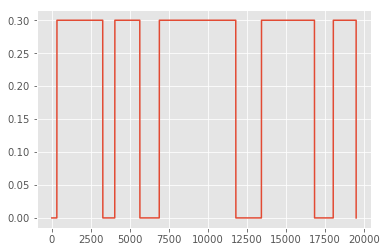

In [25]:
plt.plot(alpha)

## Make the feature vectors

#### spikes

In [48]:
#import spike_detect_aux as aux
logger.setLevel(logging.INFO)

In [62]:
#reload(aux)
reload(unitobjs)
from swissknife.bci import synthetic as syn

par_stream = syn.np_mulog(beta)

trials_train = np.arange(71)

bin_size = 3
history_bins = 30


bin_size_samples = int(bin_size*s_f/1000.)
len_samples = par_stream.shape[0]
model_pars = bp.col_binned(np.array([par_stream]), bin_size_samples)/bin_size_samples


chans_list = np.array(exp_par['channel_config']['neural'])
units_list = [unitobjs.threshUnit(ch, kwd_file=kwd_file) for ch in chans_list]


all_s_v = []
for thresh_factor in [5.5]:
    [x.set_thresh_factor(thresh_factor)for x in units_list];
    s_v_new, good_chans = unitobjs.support_vector_thresh(m_starts, len_samples, units_list,
                                   bin_size=bin_size, s_f=s_f, history_bins=history_bins+1,
                                   no_silent=False)
    all_s_v.append(s_v_new)

s_v = np.concatenate(all_s_v, axis=0)
target = np.tile(model_pars, starts.size).reshape(starts.size, -1)
logger.info('sv shape {0}, target shape {1}'.format(s_v.shape, target.shape))

2017-06-29 20:45:57,633 swissknife.bci.core.units INFO     Collecting 71 frames...
2017-06-29 20:45:57,635 swissknife.bci.core.units INFO     Frame 0 ...
2017-06-29 20:45:57,678 swissknife.bci.core.units INFO     Frame 10 ...
2017-06-29 20:45:57,719 swissknife.bci.core.units INFO     Frame 20 ...
2017-06-29 20:45:57,789 swissknife.bci.core.units INFO     Frame 30 ...
2017-06-29 20:45:57,845 swissknife.bci.core.units INFO     Frame 40 ...
2017-06-29 20:45:57,894 swissknife.bci.core.units INFO     Frame 50 ...
2017-06-29 20:45:57,939 swissknife.bci.core.units INFO     Frame 60 ...
2017-06-29 20:45:57,982 swissknife.bci.core.units INFO     Frame 70 ...
2017-06-29 20:46:00,087 swissknife.bci.core.units INFO     Will get spikes form 71 frams
2017-06-29 20:46:01,555 swissknife.bci.core.units INFO     done getting spikes
2017-06-29 20:46:01,851 root         INFO     sv shape (32, 247, 71), target shape (71, 217)


In [65]:
model_pars.shape

(1, 217)

#### Lfp

In [50]:
lfp_sv, all_spectra_fv =feature_vector_from_lfp(starts, recs, len_samples, neural_chans, kwd_file, lfp_pars, 
                           bin_size=bin_size, history_bins=history_bins+1)
print(lfp_sv.shape)

2017-06-29 20:35:28,623 root         INFO     Starts shape (71,)
2017-06-29 20:35:28,626 root         INFO     span_ms = 741
2017-06-29 20:35:28,628 root         INFO     bin_ms = 3
2017-06-29 20:35:28,631 root         INFO     Collecting 71 frames...
2017-06-29 20:35:28,633 root         INFO     Frame 0 ...
2017-06-29 20:35:28,712 root         INFO     Frame 10 ...
2017-06-29 20:35:28,776 root         INFO     Frame 20 ...
2017-06-29 20:35:28,826 root         INFO     Frame 30 ...
2017-06-29 20:35:28,871 root         INFO     Frame 40 ...
2017-06-29 20:35:28,912 root         INFO     Frame 50 ...
2017-06-29 20:35:28,954 root         INFO     Frame 60 ...
2017-06-29 20:35:29,000 root         INFO     Frame 70 ...
2017-06-29 20:35:29,007 root         INFO     Frame shape (23254, 32)
2017-06-29 20:35:29,008 root         INFO     Collecting the spectral features for the 71 frames
71it [00:57,  1.23it/s]
2017-06-29 20:36:27,016 root         INFO     all_spec_array shape (71, 32, 18, 742)
2

(576, 247, 71)


In [66]:
print(s_v.shape)
print(lfp_sv.shape)
print(target.shape)

(32, 247, 71)
(576, 247, 71)
(71, 217)


#### Merge spikes and lfp

In [73]:
from swissknife.decoder import neural as nd
reload(nd)

all_sv = np.concatenate([s_v, lfp_sv], axis=0)
#logger.info('Shape of lfp + spikes feature vector: {}'.format(all_sv.shape))
X_train, Y_train, X_test, Y_test = nd.sup_to_keras(s_v, target, history_bins, n_test=10)

2017-06-30 10:08:42,156 decoder.datashape WARNING  Size mismatch between target and support vector
2017-06-30 10:08:42,534 decoder.neural INFO     Train vector sizes (13237, 960) and (13237,)
2017-06-30 10:08:42,535 decoder.neural INFO     Test vector sizes (2170, 960) and (2170,)


## Make the networks and fit the parameters

In [74]:
from keras.layers.core import Dense, Activation
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

n_feat = X_train.shape[-1]
n_target = 1
#n_target = Y_train.shape[-1]
num_ep = 120

model = Sequential()
model.add(Dense(n_feat//2, input_dim=n_feat, kernel_initializer='uniform', activation='relu'))
#model.add(Dense(n_feat//4, input_dim=n_feat, kernel_initializer='uniform', activation='relu'))
#model.add(Dense(n_feat//8, input_dim=n_feat, kernel_initializer='uniform', activation='relu'))
model.add(Dense(n_feat//16, input_dim=n_feat, kernel_initializer='uniform', activation='relu'))
model.add(Dense(n_target, kernel_initializer='normal'))
#model.compile(loss='mean_squared_error', optimizer='adam')
model.compile(loss='mean_absolute_error', optimizer='rmsprop')


model_name = 'ff_lfp_warptemp_bs{0:02d}_hs{1:02d}_te{2:03d}.h5'.format(bin_size, history_bins, num_ep)
model_path = os.path.join(fn['folders']['ss'], 'model_' + model_name)
weights_path = os.path.join(fn['folders']['ss'], 'weights_' + model_name)
callbacks = [EarlyStopping(monitor='val_loss', patience=4, verbose=1),
             ModelCheckpoint(filepath=model_path, monitor='val_loss', save_best_only=True, verbose=1)
            ]

model.fit(X_train, Y_train, epochs=num_ep, batch_size=5, verbose=1, validation_split=0.1, 
          callbacks=callbacks)
score = model.evaluate(X_test, Y_test, batch_size=5)


Train on 11913 samples, validate on 1324 samples
Epoch 1/120
11913/11913 [==============================] - 6s - loss: 0.1139 - val_loss: 0.0931
Epoch 2/120
11913/11913 [==============================] - 5s - loss: 0.0733 - val_loss: 0.0770
Epoch 3/120
11913/11913 [==============================] - 5s - loss: 0.0602 - val_loss: 0.0696
Epoch 4/120
11913/11913 [==============================] - 5s - loss: 0.0536 - val_loss: 0.0678
Epoch 5/120
11913/11913 [==============================] - 5s - loss: 0.0481 - val_loss: 0.0655
Epoch 6/120
11913/11913 [==============================] - 5s - loss: 0.0446 - val_loss: 0.0682
Epoch 7/120
11913/11913 [==============================] - 5s - loss: 0.0416 - val_loss: 0.0636
Epoch 8/120
11913/11913 [==============================] - 5s - loss: 0.0392 - val_loss: 0.0638
Epoch 9/120
11913/11913 [==============================] - 5s - loss: 0.0374 - val_loss: 0.0654
Epoch 10/120
11913/11913 [==============================] - 5s - loss: 0.0356 - val_los

## Visualize predictions

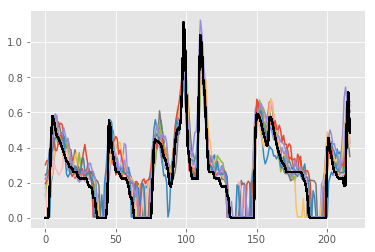

In [72]:
pred = model.predict(X_test, batch_size=5)
plt.plot((np.reshape(pred.flatten(), (10, -1)).T));
plt.plot((target.T), 'k');

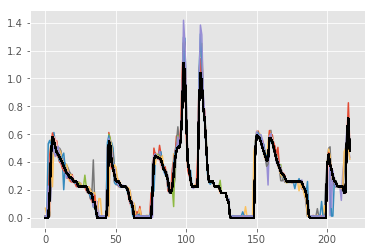

In [69]:
pred = model.predict(X_test, batch_size=5)
plt.plot((np.reshape(pred.flatten(), (10, -1)).T));
plt.plot((target.T), 'k');

In [ ]:
#5ms 20 bins history
pred = model.predict(X_test, batch_size=5)
plt.plot((np.reshape(pred.flatten(), (10, -1)).T));
plt.plot((target.T), 'k');

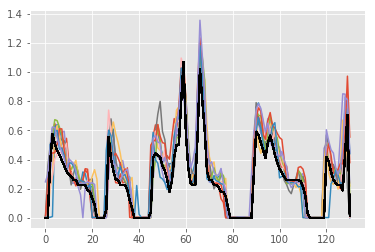

In [80]:
#4ms 25 bins history
pred = model.predict(X_test, batch_size=15)
plt.plot((np.reshape(pred.flatten(), (10, -1)).T));
plt.plot((target.T), 'k');

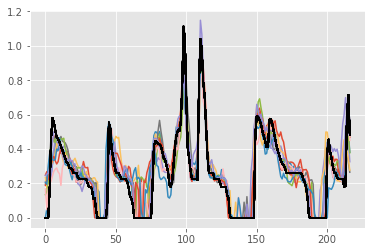

In [41]:
#3ms 25 bins history
pred = model.predict(X_test, batch_size=15)
plt.plot((np.reshape(pred.flatten(), (10, -1)).T));
plt.plot((target.T), 'k');

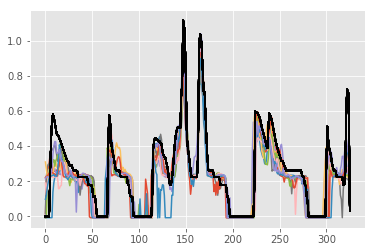

In [34]:
#2ms 30 bins history
pred = model.predict(X_test, batch_size=15)
plt.plot((np.reshape(pred.flatten(), (10, -1)).T));
plt.plot((target.T), 'k');

2017-02-06 07:48:29,152 spike_detect_aux INFO     Computer: passaro
2017-02-06 07:48:29,157 spike_detect_aux INFO     Fitting a kernel
2017-02-06 07:48:29,159 spike_detect_aux INFO     Creating support vector 32 chans, 65 trials
2017-02-06 07:48:29,161 spike_detect_aux INFO     Collecting 65 frames...
2017-02-06 07:48:29,163 spike_detect_aux INFO     Frame 0 ...
2017-02-06 07:48:29,253 spike_detect_aux INFO     Frame 10 ...
2017-02-06 07:48:29,324 spike_detect_aux INFO     Frame 20 ...
2017-02-06 07:48:29,385 spike_detect_aux INFO     Frame 30 ...
2017-02-06 07:48:29,437 spike_detect_aux INFO     Frame 40 ...
2017-02-06 07:48:29,486 spike_detect_aux INFO     Frame 50 ...
2017-02-06 07:48:29,534 spike_detect_aux INFO     Frame 60 ...
2017-02-06 07:48:34,463 spike_detect_aux INFO     sv shape (30, 87, 65), target shape (65, 60)
2017-02-06 07:48:34,581 spike_detect_aux INFO     k shape (841,)
2017-02-06 07:48:34,582 spike_detect_aux INFO     Convolving a kernel
2017-02-06 07:48:34,583 spi

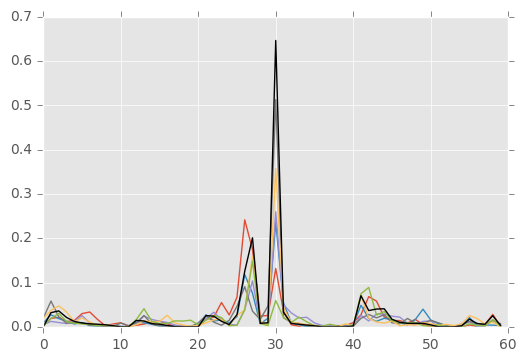

In [146]:
reload(aux)
from bci import synthetic as syn

par_stream = syn.np_mulog(beta)
from decoder import linear as ld
trials_train = np.arange(65)
trials_test = np.arange(65,71)
b_s = 11
h_b = 27
thresh_factor = 5.5
thresh = rms*thresh_factor
chans = np.arange(thresh.size)
fitted_kernel, fitted_chans = aux.linear_fit(chans, thresh, kwd_file, starts[trials_train], recs[trials_train], par_stream, 
                       bin_size=b_s, history_bins=h_b)
#fitted_kernel.flatten()
par_pred = aux.linear_predict(chans[fitted_chans], thresh[fitted_chans], kwd_file, starts[trials_test], recs[trials_test], par_stream.size, fitted_kernel, 
                   bin_size=b_s, 
                   history_bins=h_b, 
                   s_f=30000,
                   no_silent=False)

plt.plot(syn.np_mulog_inv(aux.transform_beta(par_pred)).T);
plt.plot(syn.np_mulog_inv(bp.col_binned(par_stream.reshape(1, -1), b_s*30).T/(b_s*30)), 'k');

In [147]:
nice_alpha = {'thresh_f': thresh_factor, 'bs': b_s, 'hb': h_b, 'streams': aux.transform_alpha(par_pred)}

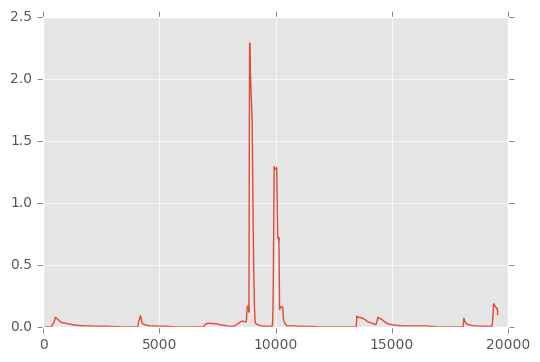

In [148]:
plt.plot(beta)

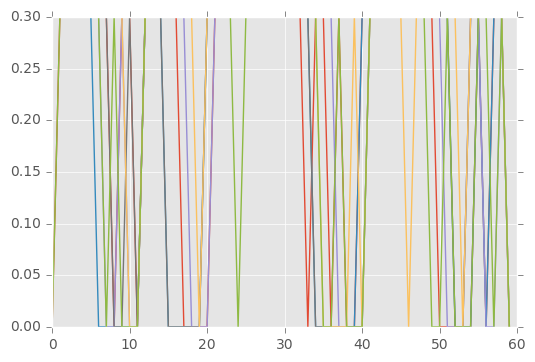

In [151]:
plt.plot(nice_alpha['streams'].T);

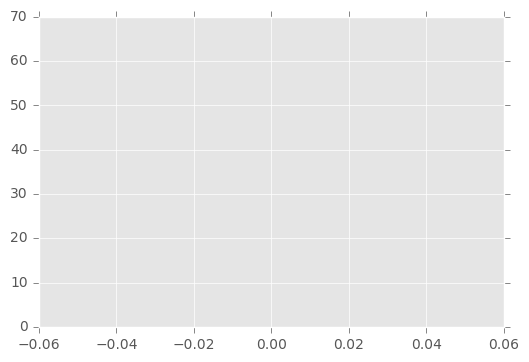

In [152]:
reload(bp)
#plt.plot(beta)
b_s = 10

plt.plot(bp.col_binned(beta.reshape(1, -1), 30));


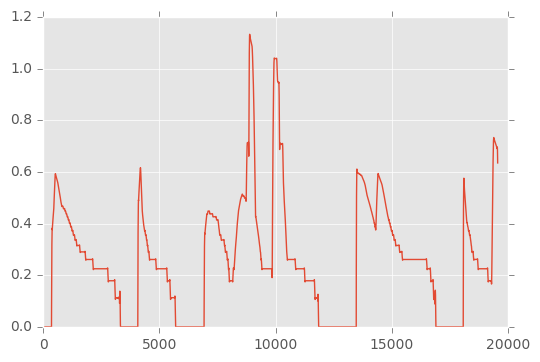

In [153]:
plt.plot(syn.np_mulog(beta))

In [154]:
nice_beta = {'thresh_f': thresh_factor, 'bs': b_s, 'hb': h_b, 'streams': aux.transform_alpha(par_pred)}

In [155]:
reload(aux)
fit_result = aux.test_fit(chans, thresh, kwd_file, starts, recs, trials_train, trials_test, par_stream,
            bin_size=b_s,
            history_bins=h_b)

2017-02-06 07:49:28,977 spike_detect_aux INFO     Computer: passaro
2017-02-06 07:49:28,979 spike_detect_aux INFO     Fitting a kernel
2017-02-06 07:49:28,981 spike_detect_aux INFO     Creating support vector 32 chans, 65 trials
2017-02-06 07:49:28,983 spike_detect_aux INFO     Collecting 65 frames...
2017-02-06 07:49:28,984 spike_detect_aux INFO     Frame 0 ...
2017-02-06 07:49:29,067 spike_detect_aux INFO     Frame 10 ...
2017-02-06 07:49:29,135 spike_detect_aux INFO     Frame 20 ...
2017-02-06 07:49:29,212 spike_detect_aux INFO     Frame 30 ...
2017-02-06 07:49:29,286 spike_detect_aux INFO     Frame 40 ...
2017-02-06 07:49:29,350 spike_detect_aux INFO     Frame 50 ...
2017-02-06 07:49:29,405 spike_detect_aux INFO     Frame 60 ...
2017-02-06 07:49:34,074 spike_detect_aux INFO     sv shape (30, 93, 65), target shape (65, 66)
2017-02-06 07:49:34,206 spike_detect_aux INFO     k shape (841,)
2017-02-06 07:49:34,207 spike_detect_aux INFO     Convolving a kernel
2017-02-06 07:49:34,208 spi

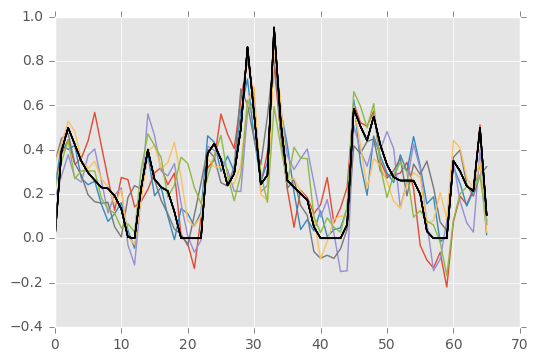

In [156]:
plt.plot(fit_result[1].T);
plt.plot(fit_result[3].T, 'k')

2017-02-06 07:50:05,814 spike_detect_aux INFO     Computer: passaro
2017-02-06 07:50:05,818 spike_detect_aux INFO     Testing for all pars with bin_size=11, history_size=29:
2017-02-06 07:50:05,819 spike_detect_aux INFO     Testing fit for a parameter
2017-02-06 07:50:05,821 spike_detect_aux INFO     Fitting a kernel
2017-02-06 07:50:05,823 spike_detect_aux INFO     Creating support vector 32 chans, 65 trials
2017-02-06 07:50:05,824 spike_detect_aux INFO     Collecting 65 frames...
2017-02-06 07:50:05,826 spike_detect_aux INFO     Frame 0 ...
2017-02-06 07:50:05,913 spike_detect_aux INFO     Frame 10 ...
2017-02-06 07:50:05,981 spike_detect_aux INFO     Frame 20 ...
2017-02-06 07:50:06,042 spike_detect_aux INFO     Frame 30 ...
2017-02-06 07:50:06,113 spike_detect_aux INFO     Frame 40 ...
2017-02-06 07:50:06,164 spike_detect_aux INFO     Frame 50 ...
2017-02-06 07:50:06,254 spike_detect_aux INFO     Frame 60 ...
2017-02-06 07:50:11,321 spike_detect_aux INFO     sv shape (30, 89, 65), 

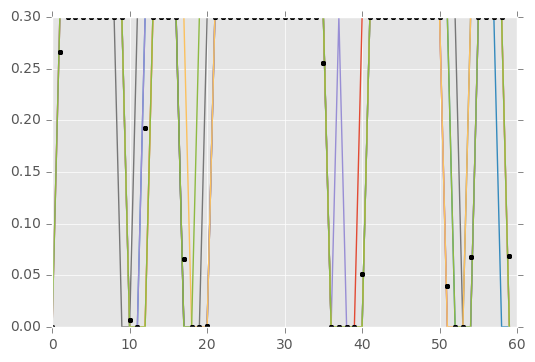

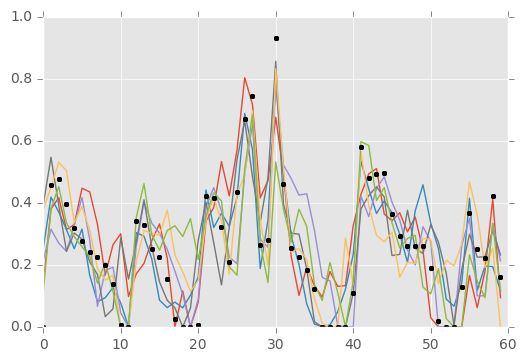

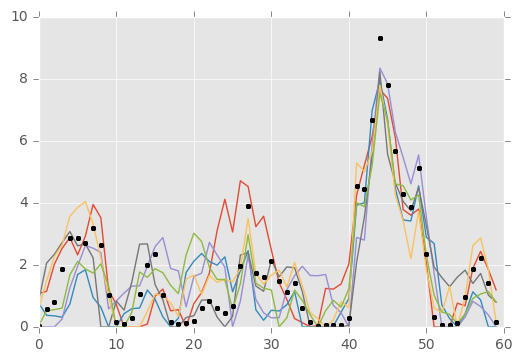

In [158]:
reload(aux)
b_s = 11
h_b = 29
thresh_factor = 5.5
thresh = rms*thresh_factor
all_result = aux.altogether_test(alpha, syn.np_mulog(beta), env, 
                                 chans, thresh, kwd_file, starts, recs, trials_train, trials_test,
                                 bin_size=b_s,
                                 history_bins=h_b)

for i_par, _ in enumerate(all_result[0]):
    plt.figure()
    plt.plot(all_result[1][i_par].T);
    plt.plot(all_result[3][i_par].T, 'k.')

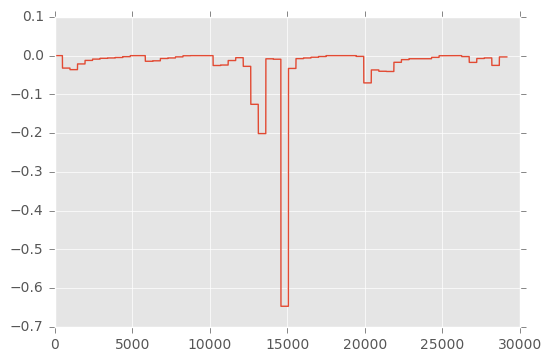

In [159]:
def resample_no_interp(x, s_f, new_s_f, axis=0):
    assert(new_s_f>=s_f)
    n_repeats = np.int(np.ceil(new_s_f/s_f))
    return np.repeat(x, n_repeats, axis=axis)

#now try to synthesise for this test
def latent_to_stream(onof, beta, alpha):
    onof[onof>.3] = .3
    onof[onof<0] = 0
    alpha[alpha<0]=0
    return np.vstack([0.15 - onof, -beta, alpha]).T

n_test = 5
fitted_streams = all_result[3][:,n_test,:]


abe_streams = latent_to_stream(fitted_streams[0, :], 
                               syn.np_mulog_inv(fitted_streams[1, :]), 
                               fitted_streams[2, :])

abe_streams_rs = resample_no_interp(abe_streams, 1000./b_s, 44100)
plt.plot(abe_streams_rs[:,1])

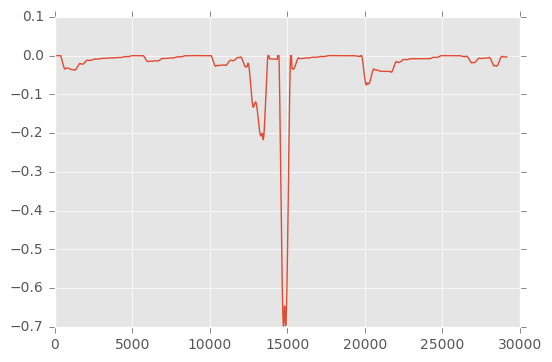

In [160]:
from scipy.signal import savgol_filter
abe_streams_rs[:,1] = savgol_filter(abe_streams_rs[:,1], 441, 3)
abe_streams_rs[abe_streams_rs[:,1] > 0, 1] = 0
# smooth_some
plt.plot(abe_streams_rs[:,1])

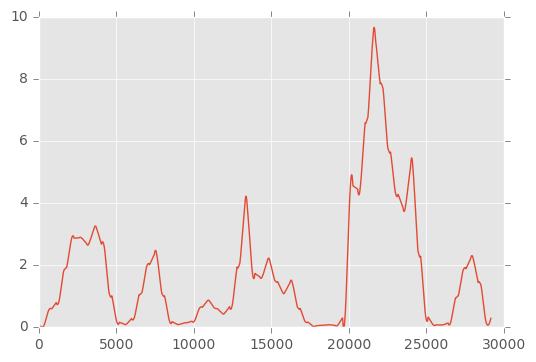

In [161]:
abe_streams_rs[:,2] = savgol_filter(abe_streams_rs[:,2], 661, 3)
abe_streams_rs[abe_streams_rs[:,2] < 0, 2] = 0
# smooth_some
plt.plot(abe_streams_rs[:,2])

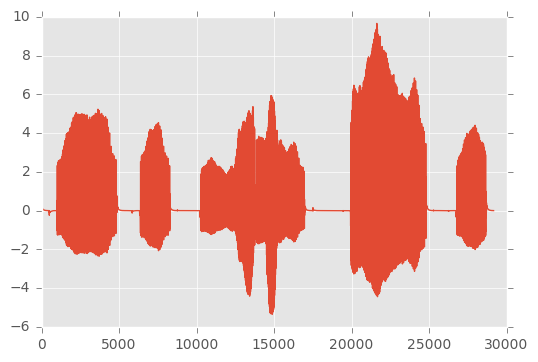

In [162]:
from dynamo import finch as zf
s_s = zf.make_song(abe_streams_rs)
plt.plot(s_s[:,0])

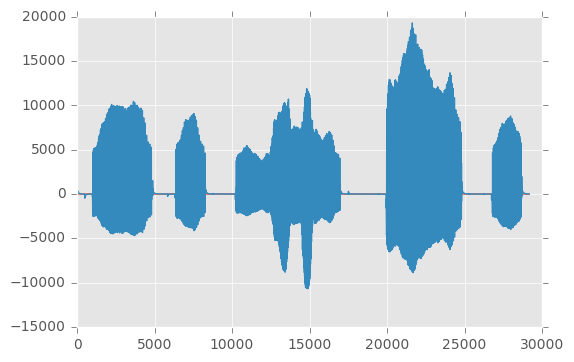

In [163]:
plt.plot(s_s[:, 0])
def wavify(x):
    return (x/np.ptp(x)*30000).astype(np.int16)

plt.plot(wavify(s_s[:, 0]))

wav_fn = os.path.join(et.file_names(bird, '002')['folders']['stim'], 'synth_thresh2.wav')
wavfile.write(wav_fn, 44100, wavify(s_s[:, 0]))


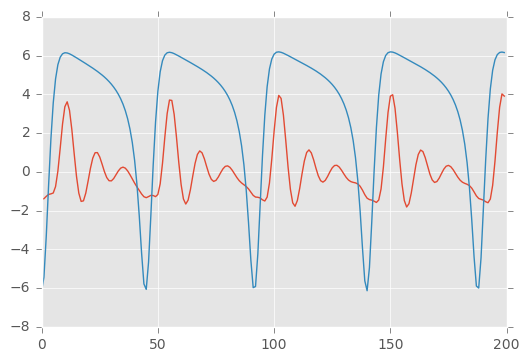

In [164]:
plt.plot(s_s[1500:1700, :])

/usr/local/anaconda/lib/python2.7/site-packages/matplotlib/axes/_base.py:2782: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))


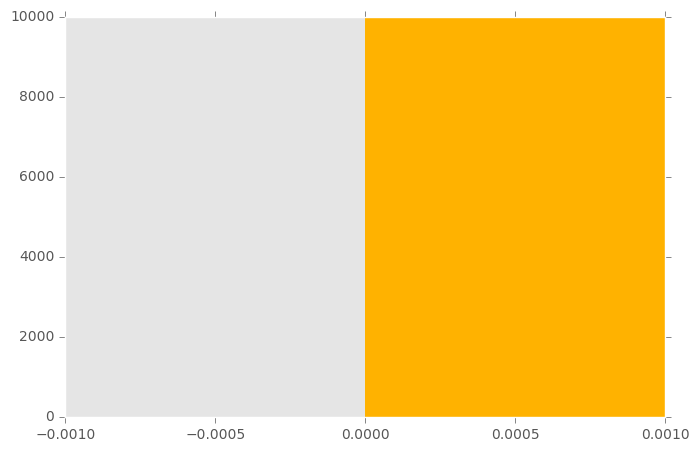

In [165]:
def plot_spectrogram(x, before_ms, after_ms, s_f, n_window = 192, n_overlap = None, sigma=None, ax=None, **kwargs):
    
    if n_overlap is None:
        n_overlap = n_window/2
    if sigma is None:
        sigma = 1./1000.*s_f
    
    # Make the spectrogram
    f, t, Sxx = spectrogram(x, s_f, nperseg = n_window, noverlap=n_overlap, window = sg.gaussian(n_window, sigma), 
                            scaling='spectrum')
    
    Sxx[[Sxx<np.max((Sxx)*0.000065)]]=1

    span_before = np.zeros((Sxx.shape[0], np.int(before_ms/1000. * s_f)))
    span_after = np.zeros((Sxx.shape[0], np.int(after_ms/1000. * s_f) + x.size - Sxx.shape[1]))
    span_before[:] = np.nan
    span_after[:] = np.nan
    #Sxx = np.hstack((span_before, (Sxx), span_after))
    
    if ax is None:
        spec_fig = plt.figure()
        ax = spec_fig.add_axes([0, 0, 1, 1])
        
    ax.pcolormesh(((t-0.5*n_window/s_f)*1000.), f, np.log(Sxx), rasterized=True)
    ax.set_xlim(-before_ms, after_ms + int(x.size/s_f * 1000.))
    ax.set_ylim(0,10000)
    #ax.plot((span_before.shape[1], span_before.shape[1]), (np.min(f), np.max(f)), 'k--')
    
    return Sxx, ax

spectr_bos, ax = plot_spectrogram(s_s[:, 0], 
                                   0, 0, 44100,
                                   n_window = 512, n_overlap=512-1, scaling='spectrum')

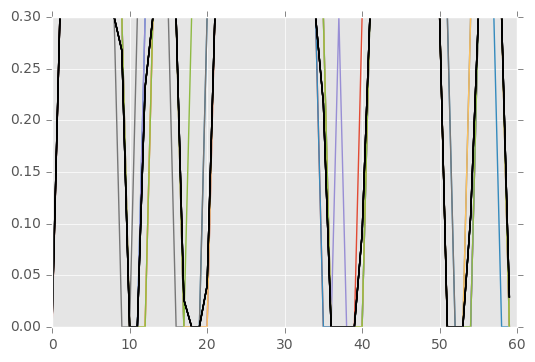

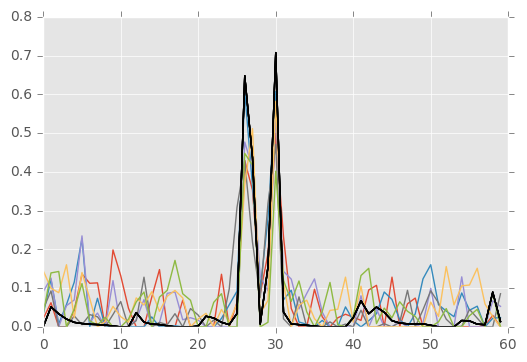

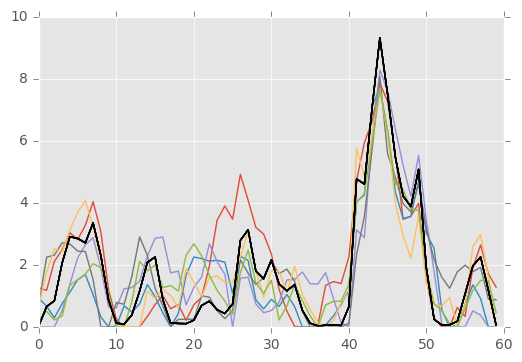

In [34]:
for i_par, _ in enumerate(all_result[0]):
    plt.figure()
    plt.plot(all_result[1][i_par].T);
    plt.plot(all_result[3][i_par].T, 'k')

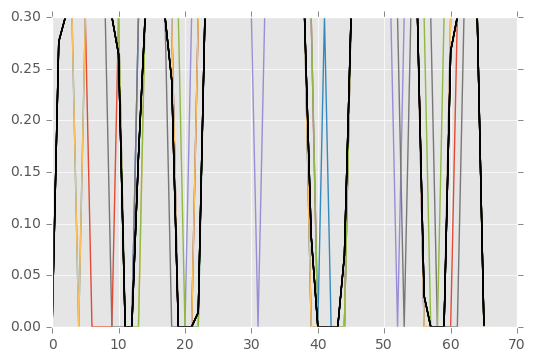

In [274]:
#plt.plot(all_result[1][0].T);
plt.plot(all_result[1][0].T);
plt.plot(all_result[3][0].T, 'k')

In [230]:
reload(aux)
env_pred = aux.linear_predict(chans[fitted_chans], thresh[fitted_chans], kwd_file, starts[trials_test], recs[trials_test], env.size, 
                              fitted_kernel, 
                   bin_size=b_s, 
                   history_bins=h_b, 
                   s_f=30000,
                   no_silent=False)

2016-12-13 10:39:17,631 spike_detect_aux INFO     Computer: passaro
2016-12-13 10:39:17,633 spike_detect_aux INFO     k shape (465,)
2016-12-13 10:39:17,635 spike_detect_aux INFO     Convolving a kernel
2016-12-13 10:39:17,636 spike_detect_aux INFO     Channels are 29
2016-12-13 10:39:17,638 spike_detect_aux INFO     Creating support vector 29 chans, 6 trials
2016-12-13 10:39:17,639 spike_detect_aux INFO     Collecting 6 frames...
2016-12-13 10:39:17,641 spike_detect_aux INFO     Frame 0 ...
2016-12-13 10:39:18,073 spike_detect_aux INFO     kernel shape (465,), sv_shape (29, 81, 6), len_samples 19503


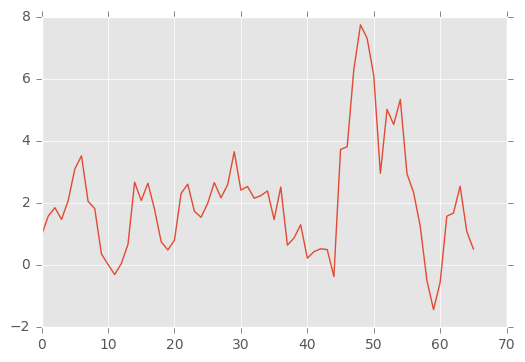

In [251]:
plt.plot(env_pred[1])

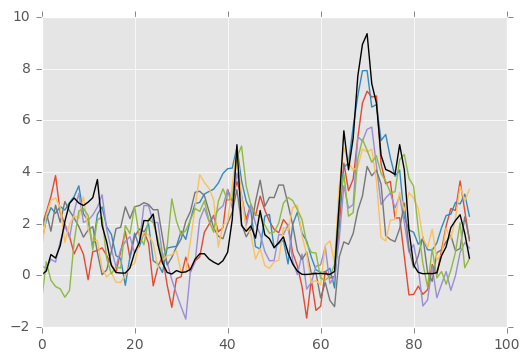

In [185]:
plt.plot(env_pred.T);
plt.plot(bp.col_binned(env.reshape(1, -1), b_s*30).T/(b_s*30), 'k');

In [178]:
all_result = aux.altogether_test(alpha, beta, env, 
                                 chans, thresh, kwd_file, starts, recs, trials_train, trials_test,
                                 bin_size=b_s,
                                 history_bins=h_b)

array([[ 0.11122297,  0.10719738,  0.10260112, ...,  2.7971164 ,
         2.64351626,  1.48117981]])

In [289]:
s_f

30000

In [293]:
bins = [5, 6, 7, 8, 9, 10, 12, 15]
histories = [5, 6, 7, 8, 9, 10, 12, 15, 17, 20, 22, 25, 27]
tests_sweep = []
for bs in bins:
    bs_sweep = []
    for hs in histories:
        logger.info('Testing with bs={0}, hs={1}:'.format(bs, hs))
        ev_tst = aux.altogether_test(alpha, syn.np_mulog(beta, 256), env, 
                                 chans, thresh, kwd_file, starts, recs, trials_train, trials_test,
                             bin_size=bs, 
                             history_bins=hs, 
                             s_f=s_f, 
                             nl_alpha = aux.transform_alpha, 
                             nl_beta = aux.transform_beta, 
                             nl_env = aux.transform_env
                            )
        bs_sweep.append(ev_tst)
    tests_sweep.append(bs_sweep)

2016-12-13 13:03:18,698 root         INFO     Testing with bs=5, hs=5:
2016-12-13 13:03:18,702 spike_detect_aux INFO     Testing for all pars with bin_size=5, history_size=5:
2016-12-13 13:03:18,703 spike_detect_aux INFO     Testing fit for a parameter
2016-12-13 13:03:18,705 spike_detect_aux INFO     Fitting a kernel
2016-12-13 13:03:18,707 spike_detect_aux INFO     Creating support vector 32 chans, 65 trials
2016-12-13 13:03:18,708 spike_detect_aux INFO     Collecting 65 frames...
2016-12-13 13:03:18,709 spike_detect_aux INFO     Frame 0 ...
2016-12-13 13:03:18,777 spike_detect_aux INFO     Frame 10 ...
2016-12-13 13:03:18,832 spike_detect_aux INFO     Frame 20 ...
2016-12-13 13:03:18,884 spike_detect_aux INFO     Frame 30 ...
2016-12-13 13:03:18,925 spike_detect_aux INFO     Frame 40 ...
2016-12-13 13:03:18,963 spike_detect_aux INFO     Frame 50 ...
2016-12-13 13:03:19,000 spike_detect_aux INFO     Frame 60 ...
2016-12-13 13:03:22,301 spike_detect_aux INFO     sv shape (32, 136, 65)

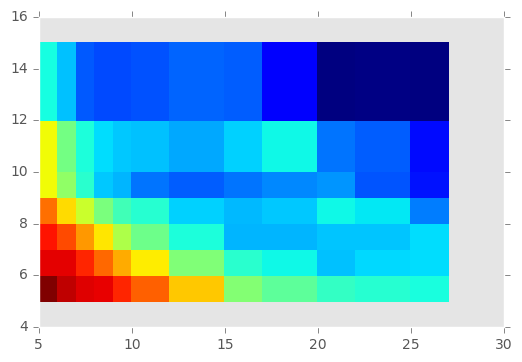

In [320]:
import itertools
n_bs = len(bins)
n_hs = len(histories)
k_par = 1

res_array = np.zeros([n_bs, n_hs, 3])
for b, h in itertools.product(range(n_bs), range(n_hs)):
    res_array[b, h, :] = tests_sweep[b][h][2]
plt.pcolormesh(histories, bins, res_array[:,:,k_par])

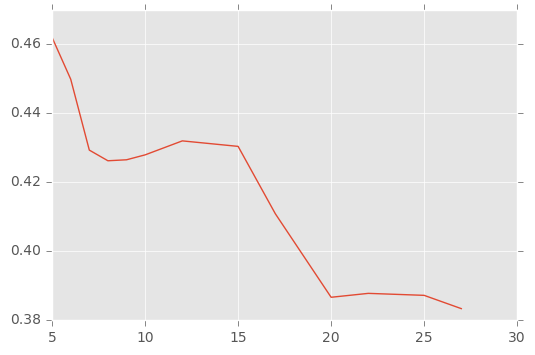

In [324]:
plt.plot(histories, res_array[6,:,k_par])

In [122]:
os.path.join('tuvieja', 'tar', '')

'tuvieja/tar/'

In [124]:
mode = 'w:'
ext = mode.split(':')[-1]

In [126]:
ext == ''

True

In [128]:
file_name = '{0}.tar'.format('tuvieja')

In [129]:
file_name+= '.{0}'.format(ext)

In [130]:
file_name

'tuvieja.tar.'